In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [4]:
X_df = pd.read_csv('../new_data/NA/na_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/NA/na_labels.csv', usecols=['filename', 'emotions'], index_col='filename')
Y_df["emotions"] = Y_df["emotions"].apply(eval)
unique_items = to_1D(Y_df["emotions"]).unique()
labels_expanded = boolean_df(Y_df['emotions'], unique_items)
labels_expanded

,none,furious,anger,annoyed,contempt,disgust,hatred
filename,,,,,,,
na/vid_1.mp4,1,0,0,0,0,0,0
na/vid_100.mp4,0,1,0,0,0,0,0
na/vid_101.mp4,0,1,0,0,0,0,0
na/vid_102.mp4,0,0,1,0,0,0,0
na/vid_104.mp4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
na/vid_90.mp4,0,0,1,0,0,0,0
na/vid_92.mp4,0,0,1,0,0,0,0
na/vid_93.mp4,0,0,1,0,0,0,0


In [5]:
X_df['none']  = np.NaN
X_df['furious']  = np.NaN
X_df['anger']  = np.NaN
X_df['annoyed']  = np.NaN
X_df['contempt']  = np.NaN
X_df['disgust']  = np.NaN
X_df['hatred']  = np.NaN


In [ ]:
X_df.head()

In [6]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
    X_df.at[index,'none'] = labels_expanded.at[filename,'none']
    X_df.at[index,'furious'] = labels_expanded.at[filename,'furious']
    X_df.at[index,'anger'] = labels_expanded.at[filename,'anger']
    X_df.at[index,'annoyed'] = labels_expanded.at[filename,'annoyed']
    X_df.at[index,'contempt'] = labels_expanded.at[filename,'contempt']
    X_df.at[index,'disgust'] = labels_expanded.at[filename,'disgust']
    X_df.at[index,'hatred'] = labels_expanded.at[filename,'hatred']

### Min-Max Scaling

In [22]:
## Ablation cols
# ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']
ablation_cols = ['pose_Rx','pose_Ry','pose_Rz','gaze_angle_x','gaze_angle_y']

In [23]:
X_df = X_df.drop(columns=ablation_cols)
X_df

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,AU25_r,AU26_r,AU45_r,none,furious,anger,annoyed,contempt,disgust,hatred
0,na/vid_1.mp4,north american,1,0,0.000,0.98,1,1.45,1.86,0.00,...,0.66,0.20,1.97,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,na/vid_1.mp4,north american,2,0,0.017,0.98,1,1.50,1.98,0.00,...,0.69,0.33,1.86,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,na/vid_1.mp4,north american,3,0,0.033,0.98,1,1.57,1.98,0.00,...,0.69,0.31,1.88,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,na/vid_1.mp4,north american,4,0,0.050,0.98,1,1.56,1.99,0.00,...,0.67,0.24,1.89,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,na/vid_1.mp4,north american,5,0,0.067,0.98,1,1.40,1.94,0.00,...,0.65,0.28,1.92,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6871,na/vid_97.mp4,north american,92,0,3.792,0.88,1,0.66,0.00,2.70,...,1.22,1.17,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6872,na/vid_97.mp4,north american,93,0,3.833,0.88,1,0.00,0.00,2.74,...,0.76,1.34,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6873,na/vid_97.mp4,north american,94,0,3.875,0.88,1,0.08,0.00,2.85,...,0.57,0.44,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6874,na/vid_97.mp4,north american,95,0,3.917,0.88,1,0.00,0.00,2.96,...,0.91,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success', 'none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred'])
)
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test

In [25]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
print(X_df.head())
videos = X_df['filename'].unique()
test_videos = pd.Series(videos).sample(frac=0.20)
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
y_test = test_df[['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']].values
X_test = test_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values

       filename         culture  frame  face_id  timestamp  confidence  \
0  na/vid_1.mp4  north american      1        0      0.000        0.98   
1  na/vid_1.mp4  north american      2        0      0.017        0.98   
2  na/vid_1.mp4  north american      3        0      0.033        0.98   
3  na/vid_1.mp4  north american      4        0      0.050        0.98   
4  na/vid_1.mp4  north american      5        0      0.067        0.98   

   success  AU01_r  AU02_r  AU04_r  ...  AU25_r  AU26_r  AU45_r  none  \
0        1    1.45    1.86     0.0  ...    0.66    0.20    1.97   1.0   
1        1    1.50    1.98     0.0  ...    0.69    0.33    1.86   1.0   
2        1    1.57    1.98     0.0  ...    0.69    0.31    1.88   1.0   
3        1    1.56    1.99     0.0  ...    0.67    0.24    1.89   1.0   
4        1    1.40    1.94     0.0  ...    0.65    0.28    1.92   1.0   

   furious  anger  annoyed  contempt  disgust  hatred  
0      0.0    0.0      0.0       0.0      0.0     0.0  
1   

In [26]:
y_test[800:805,:]


array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [27]:
metadata_test.iloc[800:805]

,frame,face_id,culture,filename,timestamp
4098,108,0,north american,na/vid_60.mp4,3.570
4099,109,0,north american,na/vid_60.mp4,3.604
4100,110,0,north american,na/vid_60.mp4,3.637
4101,111,0,north american,na/vid_60.mp4,3.670
4102,112,0,north american,na/vid_60.mp4,3.704


## Cross-validation

### Classifier Chain

In [66]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

kfold = KFold(5, True, 1)
mean_hm_test = []
mean_jac_test = []

splits = kfold.split(train_videos, labels_expanded.loc[train_videos])
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y = train_df[['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']].values
    X = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()

    chains = [ClassifierChain(base_knn, order='random', random_state=i)
            for i in range(4)]
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        # valid_pred = model.predict(X_valid)
        # val_score =jaccard_score(y_valid, valid_pred, average='samples')
        # print('Validation score in model %d: %d' % (j, val_score) )
        
    # predict on validation data
    valid_pred_chains = np.array([chain.predict(X_valid) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_valid, valid_pred_chain >= .5,
                                    average='samples')
                    for valid_pred_chain in valid_pred_chains]
    
    print("Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_valid, valid_pred_chain >= .5)
                for valid_pred_chain in valid_pred_chains]
    print("Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = np.array([chain.predict(X_test) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5,
                                    average='samples')
                    for Y_pred_chain in Y_pred_chains]
    mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_test, Y_pred_chain) 
                for Y_pred_chain in Y_pred_chains]
    mean_hm_test.append(np.mean(chain_hamming_loss))
    print("Test Hamming Loss:\n ", chain_hamming_loss)
    
    


1-th split: train: 60, test: 15
Training+validation data size:  4494
Training data size:  3370
Validation data size:  1124
Validation Jaccard Score:
  [1.0, 1.0, 1.0, 1.0]
Validation Hamming Loss:
  [0.0, 0.0, 0.0, 0.0]
Test Jaccard Score: 
  [1.0, 1.0, 1.0, 1.0]
Test Hamming Loss:
  [0.0, 0.0, 0.0, 0.0]
2-th split: train: 60, test: 15
Training+validation data size:  4489
Training data size:  3366
Validation data size:  1123
Validation Jaccard Score:
  [1.0, 1.0, 1.0, 1.0]
Validation Hamming Loss:
  [0.0, 0.0, 0.0, 0.0]
Test Jaccard Score: 
  [1.0, 1.0, 1.0, 1.0]
Test Hamming Loss:
  [0.0, 0.0, 0.0, 0.0]
3-th split: train: 60, test: 15
Training+validation data size:  3960
Training data size:  2970
Validation data size:  990
Validation Jaccard Score:
  [1.0, 1.0, 1.0, 1.0]
Validation Hamming Loss:
  [0.0, 0.0, 0.0, 0.0]
Test Jaccard Score: 
  [1.0, 1.0, 1.0, 0.9793791071833219]
Test Hamming Loss:
  [0.0, 0.0, 0.0, 0.008837525492861998]
4-th split: train: 60, test: 15
Training+validation

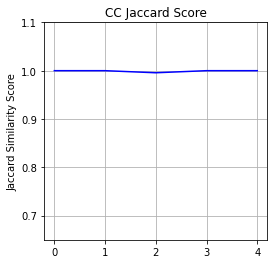

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.65, 1.1])
plt.plot(mean_jac_test, label='Jaccard Score', color='blue')
plt.show()

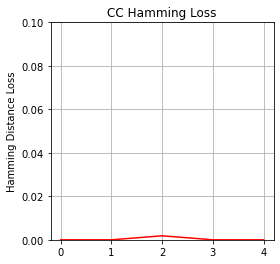

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.0, 0.1])
plt.plot(mean_hm_test, label='Hamming Loss', color='red')
plt.show()

### ML KNN

In [54]:
from skmultilearn.adapt import MLkNN, MLTSVM
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
mean_hm_test = []
mean_jac_test = []

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y = train_df[['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']].values
    X = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
   
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

1-th split: train: 60, test: 15
Training+validation data size:  4494
Training data size:  3370
Validation data size:  1124
Validation Hamming Loss:
  0.0026690391459074734
Test Hamming Loss:
  0.019131785957074876
Test Jaccard Score:
  0.9320190346702923
2-th split: train: 60, test: 15
Training+validation data size:  4489
Training data size:  3366
Validation data size:  1123
Validation Hamming Loss:
  0.0024169952932196924
Test Hamming Loss:
  0.032145285034476064
Test Jaccard Score:
  0.8808067074552458
3-th split: train: 60, test: 15
Training+validation data size:  3960
Training data size:  2970
Validation data size:  990
Validation Hamming Loss:
  0.004184704184704185
Test Hamming Loss:
  0.05545304457609012
Test Jaccard Score:
  0.8090867890324042
4-th split: train: 60, test: 15
Training+validation data size:  4297
Training data size:  3222
Validation data size:  1075
Validation Hamming Loss:
  0.0018604651162790699
Test Hamming Loss:
  0.017286588326697095
Test Jaccard Score:
  0.

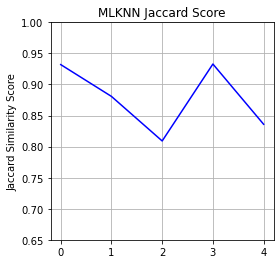

In [55]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.65, 1.0])
plt.plot(mean_jac_test, label='Jaccard Score', color='blue')
plt.show()

In [56]:
mean_jac_test


[0.9320190346702923,
 0.8808067074552458,
 0.8090867890324042,
 0.9329254475413551,
 0.8359392703376387]

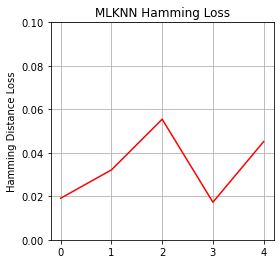

In [57]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
plt.plot(mean_hm_test, label='Hamming Loss', color='red')
plt.show()

In [58]:
mean_hm_test

[0.019131785957074876,
 0.032145285034476064,
 0.05545304457609012,
 0.017286588326697095,
 0.045158784111877244]

In [ ]:
train_df.head()

Multilabel confusion matrix puts TN at (0,0) and TP at (1,1) position thanks @Kenneth Witham for pointing out.


In [60]:
multilabel_confusion_matrix(y_test, y_test_pred, labels=range(0,7))


array([[[1391,    8],
        [   0,   72]],

       [[1314,    5],
        [  53,   99]],

       [[1265,   21],
        [  51,  134]],

       [[ 811,   15],
        [  42,  603]],

       [[1101,  158],
        [  29,  183]],

       [[1001,   83],
        [   0,  387]],

       [[1471,    0],
        [   0,    0]]])

`support`: The number of occurrences of each label in y_true.

In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']))

              precision    recall  f1-score   support

        none       0.90      1.00      0.95        72
     furious       0.95      0.65      0.77       152
       anger       0.86      0.72      0.79       185
     annoyed       0.98      0.93      0.95       645
    contempt       0.54      0.86      0.66       212
     disgust       0.82      1.00      0.90       387
      hatred       0.00      0.00      0.00         0

   micro avg       0.84      0.89      0.86      1653
   macro avg       0.72      0.74      0.72      1653
weighted avg       0.87      0.89      0.87      1653
 samples avg       0.84      0.88      0.85      1653



1471

In [85]:
print(type(y_test[0]))
print(type(y_test_pred[0].toarray()))
for i in range(len(y_test)):
    if metrics.hamming_loss(y_test[i].flatten(), Y_pred_chains[4][i].flatten()) > 0:
        print("Ground Truth: ", y_test[i], ", Prediction: ", Y_pred_chains[0][i])
        print("Video data: ", metadata_test.iloc[i])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

## Break data into chunks of 50 frames or less

In [ ]:
grouped = X_df.groupby(by=['filename', 'face_id'])
## Separating test data
test_ts_list = list()
test_metadata = list()
# X_list is video/face frames, divided into 50 frames chunks
X_list = []
Y_list = []
metadata = []
frame_limit = 50
for key in grouped.groups:
    X_group = grouped.get_group(key)
    # X_group = X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1)
    if len(X_group) >= frame_limit:
        splitted_group = np.array_split(X_group, math.ceil(len(X_group) / frame_limit))
        for g in splitted_group:
            X_list.append(g.drop(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'], axis=1).to_numpy())
            metadata.append({'filename': g.loc[g.index[0], 'filename'], 'face_id':g.loc[g.index[0], 'face_id']})
            Y_list.append(Y_df.loc[g.loc[g.index[0], 'filename']].to_list())
    else:
        X_list.append(X_group.drop(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'], axis=1).to_numpy())
        metadata.append({'filename': X_group.loc[X_group.index[0], 'filename'],  'face_id':X_group.loc[X_group.index[0], 'face_id']})
        Y_list.append(Y_df.loc[g.loc[g.index[0], 'filename']].to_list())

In [ ]:
X_ts = to_time_series_dataset(X_list)

n_series = len(X_ts)
distance_matrix = np.zeros(shape=(n_series, n_series))

# Build distance matrix
for i in range(n_series):
    for j in range(n_series):
        x = X_ts[i]
        y = X_ts[j]
        if i != j:
            dist = soft_dtw(x, y)
            distance_matrix[i, j] = dist

https://scikit-learn.org/stable/modules/multiclass.html#classifierchain


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
X_train, X_test, Y_train, Y_test = train_test_split(X_ts, Y_list, test_size=.2,
                                                    random_state=0)

base_knn =  KNeighborsClassifier(n_neighbors=5)
chains = [ClassifierChain(base_knn, order='random', random_state=i)
          for i in range(7)]
for model in chains:
    model.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])



In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)